# Прогнозирование вероятности оттока пользователей для фитнес-центров

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Част клиентов со временем перестает посещать фитнес-центр. 

**Цели исследования:** 
1. Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
1. Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
1. Проанализировать основные признаки, наиболее сильно влияющие на отток;
1. Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами

**Ход исследования:**
1. Загрузка данных
1. Исследовательский анализ данных (EDA)
1. Построение модели прогнозирования оттока клиентов
1. Кластеризацию клиентов
1. Формирование рекомендаций по работе с клиентами

## Загрузка данных

In [1]:
#Импортируем библиотеки
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools

In [2]:
#Получаем данные из файла
path = '/datasets/'
data = pd.read_csv(path + 'gym_churn.csv')

In [3]:
#проверяем содержимое
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Числовые признаки: 
- Возраст
- Средняя выручка
- Количество месяцев до окончания договора
- Время с момента первого обращения в фитнес-центр (в месяцах)
- Средняя частота посещений в неделю за все время с начала действия абонемента
- Средняя частота посещений в неделю за предыдущий месяц
- Cуммарная выручка от других услуг фитнес-центра

Остальные признаки являются категориальными

## Исследовательский анализ данных (EDA)

In [32]:
# проверим описание файла 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Пропусков нет 


In [33]:
#проверим характеристики данных
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Наибольший разброс от среднего значения у признака `Avg_additional_charges_total` (суммарная выручка от других услуг фитнес-центра)

**Проверим средние значения признаков в группах: клиенты попавшие в отток и не попавшие**

In [34]:
#чтобы все даннные отображались на экране изменим количество отображаемых строк и столбцов
pd.set_option('display.max_columns', 1000)  
pd.set_option('display.max_rows', 1000)  

In [35]:
#сгруппируем данные по признаку оттока
data.groupby("Churn").describe().T

Churn                                              0            1
gender                            count  2939.000000  1061.000000
                                  mean      0.510037     0.510839
                                  std       0.499984     0.500118
                                  min       0.000000     0.000000
                                  25%       0.000000     0.000000
                                  50%       1.000000     1.000000
                                  75%       1.000000     1.000000
                                  max       1.000000     1.000000
Near_Location                     count  2939.000000  1061.000000
                                  mean      0.873086     0.768143
                                  std       0.332933     0.422217
                                  min       0.000000     0.000000
                                  25%       1.000000     1.000000
                                  50%       1.000000     1.000000
                                  75%       1.000000     1.000000
                                  max       1.000000     1.000000
Partner                           count  2939.000000  1061.000000
                                  mean      0.534195     0.355325
                                  std       0.498914     0.478837
                                  min       0.000000     0.000000
                                  25%       0.000000     0.000000
                                  50%       1.000000     0.000000
                                  75%       1.000000     1.000000
                                  max       1.000000     1.000000
Promo_friends                     count  2939.000000  1061.000000
                                  mean      0.353522     0.183789
                                  std       0.478144     0.387495
                                  min       0.000000     0.000000
                                  25%       0.000000     0.000000
                                  50%       0.000000     0.000000
                                  75%       1.000000     0.000000
                                  max       1.000000     1.000000
Phone                             count  2939.000000  1061.000000
                                  mean      0.903709     0.902922
                                  std       0.295040     0.296204
                                  min       0.000000     0.000000
                                  25%       1.000000     1.000000
                                  50%       1.000000     1.000000
                                  75%       1.000000     1.000000
                                  max       1.000000     1.000000
Contract_period                   count  2939.000000  1061.000000
                                  mean      5.747193     1.728558
                                  std       4.716942     2.132371
                                  min       1.000000     1.000000
                                  25%       1.000000     1.000000
                                  50%       6.000000     1.000000
                                  75%      12.000000     1.000000
                                  max      12.000000    12.000000
Group_visits                      count  2939.000000  1061.000000
                                  mean      0.464103     0.268615
                                  std       0.498795     0.443448
                                  min       0.000000     0.000000
                                  25%       0.000000     0.000000
                                  50%       0.000000     0.000000
                                  75%       1.000000     1.000000
                                  max       1.000000     1.000000
Age                               count  2939.000000  1061.000000
                                  mean     29.976523    26.989632
                                  std       3.009933     2.895163
                                  min   

- Не попавших в отток почти в 3 раза больше, чем попавших
- Средние значения сильно отличаются следующих признаков
    - Contract_period (длительность текущего действующего абонемента): не попавшие в отток заключают договор на более длительный срок
    - Month_to_end_contract (срок до окончания текущего действующего абонемента): у попавших в отток остается в среднем меньше 2-х месяцев, а у не попавших - 5
    - Lifetime (время с момента первого обращения в фитнес-центр): не попавшие в отток среднем обратились 5 месяцев назад, а попавшие - 1


**Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)**

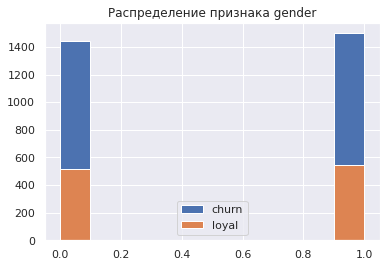

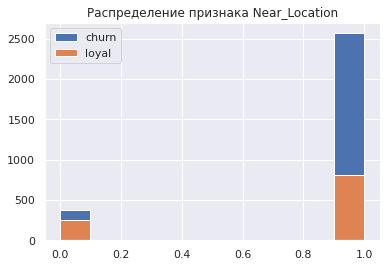

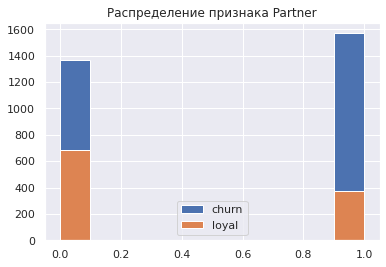

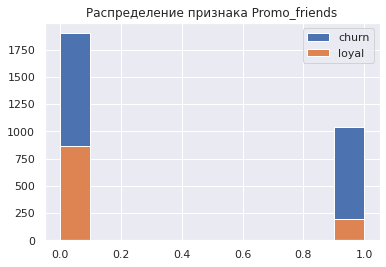

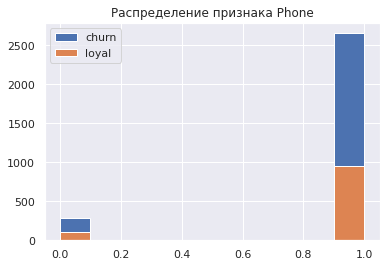

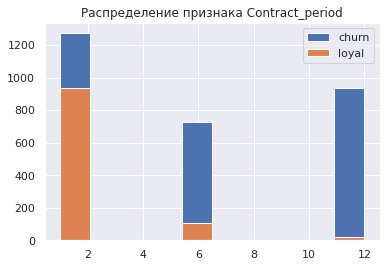

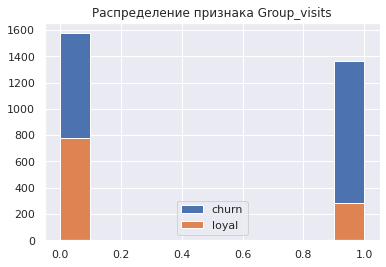

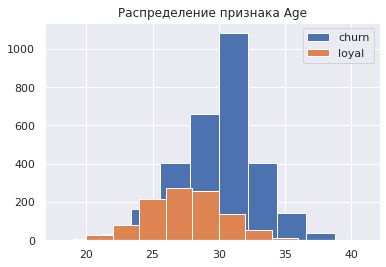

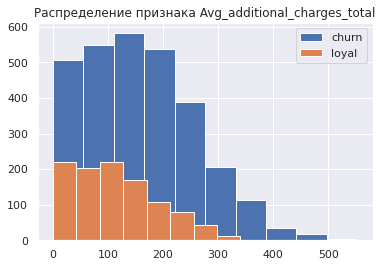

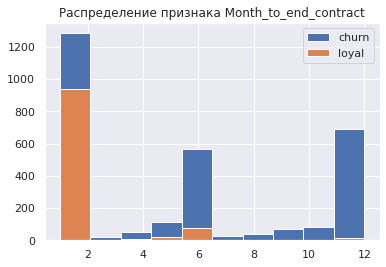

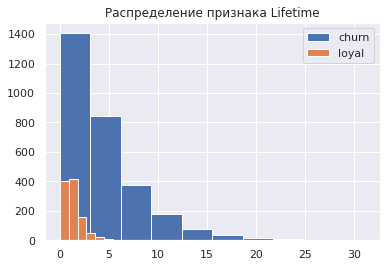

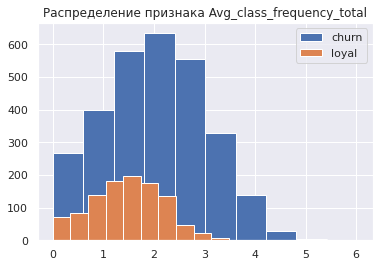

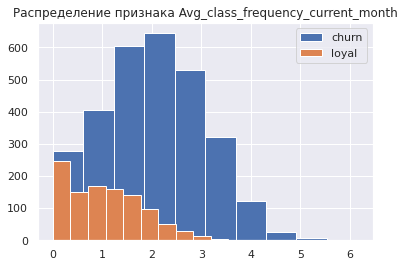

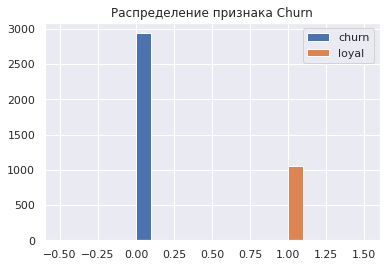

In [36]:
for col in data.columns:
    fig, ax = plt.subplots(figsize=(6,4))
    data.groupby('Churn')[col].hist()
    plt.title('Распределение признака ' + col)
    plt.legend(['churn', 'loyal'])

**Построим матрицу корреляций и отобразим в виде тепловой карты**


<AxesSubplot:>

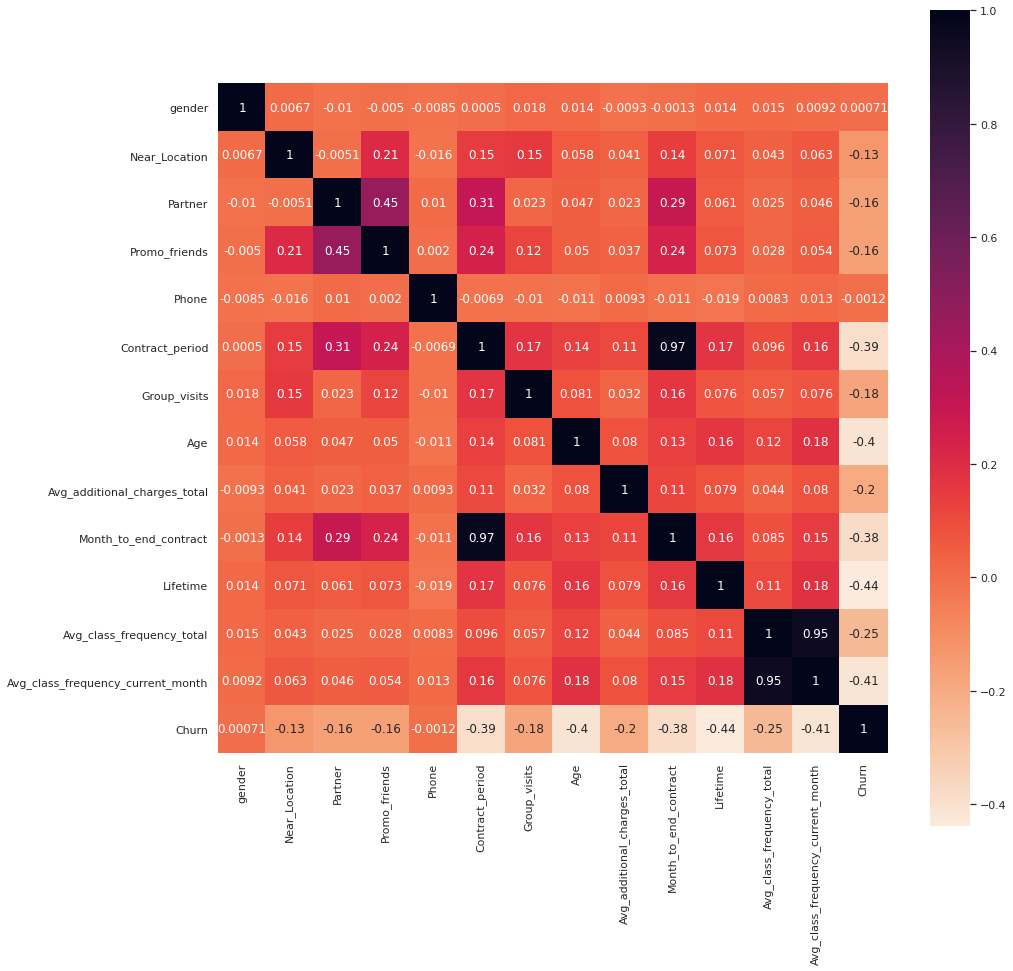

In [37]:
#зададим размер фигуры 
sns.set(rc={'figure.figsize':(15,15)})
#построим тепловую карту 
sns.heatmap(data.corr(), annot=True, square=True, cmap = sns.cm.rocket_r)

Признаки, коррелирующие между собой: 
- `Contract_period` и `Lifetime` - чем раньше клиент обратился, тем на больший срок у него контракт 
- `Avg_class_frequency_total` и `Avg_class_frequency_current_month` - в среднем клиенты посещеают клуб с одинаковой частовой как в текущем месяце, так и за все время действия абонемента

## Построение модели прогнозирования оттока клиентов

### Разделение на обучающую и валидационную выборки

Разделим данные на обучающую и валидационную выборки

In [38]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('Churn', axis = 1)
y = data['Churn']

In [39]:
#разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Логистрическая регрессия

Обучим модель логистической регрессией

In [40]:
#обучим модель логистической регрессией
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [41]:
#делаем прогнозы
lr_predictions = lr_model.predict(X_test) 
lr_probabilities = lr_model.predict_proba(X_test)[:,1] 

### Случайный лес

Обучим модель рандомным лесом

In [42]:
#обучим модель рандомным лесом
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [43]:
#делаем прогнозы
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

### Рассчет метрик

Рассчитаем метрики

In [44]:
# определим функцию, которая будет выводить метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [45]:
#вызовем функцию для логистической регрессии
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83


In [46]:
#вызовем функцию для случайного леса
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:',
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82


Все метрики имеют примерно одинаковое значение для обеих моделей. И все 3 метрики имеют показатели близкие к 1. Это показывает хорошее качество моделей.

## Кластеризация клиентов

### Стандартизация данных

In [47]:
#создадим объект класса StandardScaler
scaler = StandardScaler()

In [48]:
#применим к обучающей выборке
x_sc = scaler.fit_transform(data.drop(columns = ['Churn']))

### Матрица расстояний

In [49]:
#строим матрицу расстояний
linked = linkage(x_sc, method = 'ward') 

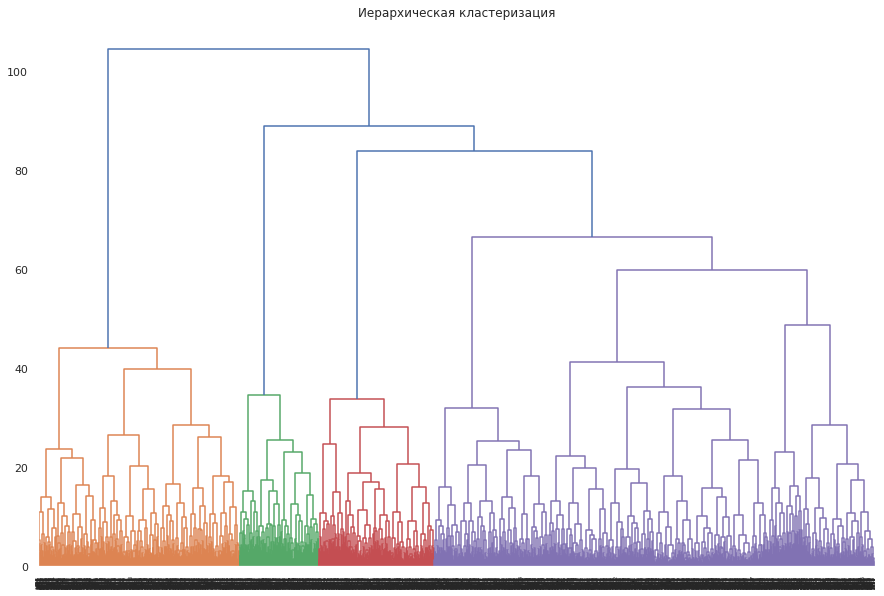

In [50]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show() 

Алгоритм разделил данные на 4 кластера.

### Обучение модели кластеризации

In [51]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
print(data.groupby(['cluster_km']).mean())

              gender  Near_Location   Partner  Promo_friends     Phone  \
cluster_km                                                               
0           0.502970       0.959406  0.783168       0.574257  1.000000   
1           0.522078       0.862338  0.470130       0.306494  0.000000   
2           0.495050       0.000000  0.463366       0.079208  1.000000   
3           0.485737       1.000000  0.350238       0.240095  1.000000   
4           0.559666       0.976134  0.356802       0.230310  0.998807   

            Contract_period  Group_visits        Age  \
cluster_km                                             
0                 10.889109      0.542574  29.982178   
1                  4.787013      0.425974  29.301299   
2                  2.352475      0.215842  28.477228   
3                  1.948494      0.341521  28.167987   
4                  2.669451      0.473747  30.125298   

            Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster_km 

Пользователи из кластера 0 покупают абонемент на больший период времени, у них остается больше месяцев до конца абонемента и доля оттока у них ниже.  
Наибольшие доля оттока у пользователей из кластера 3. Эти клиенты берут абонемент на небольшой срок.

### Распределение признаков для кластеров

In [52]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        x=df[x_name], y=df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

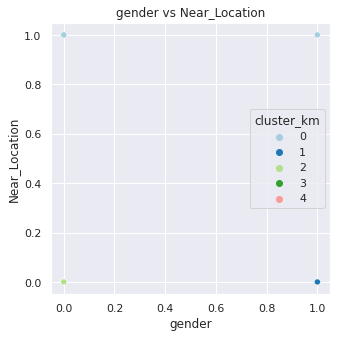

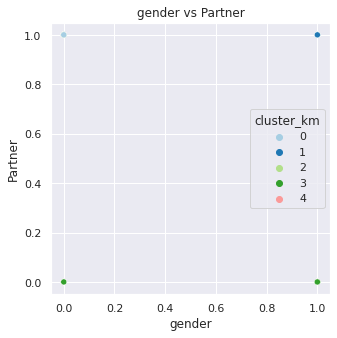

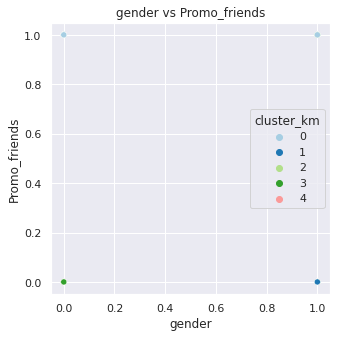

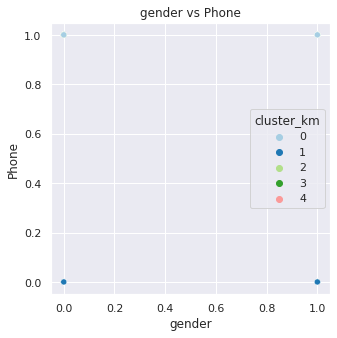

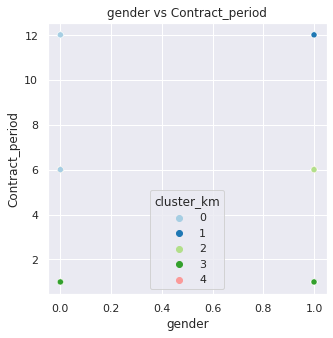

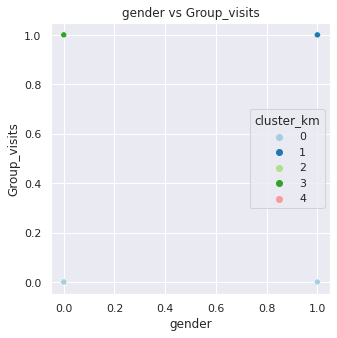

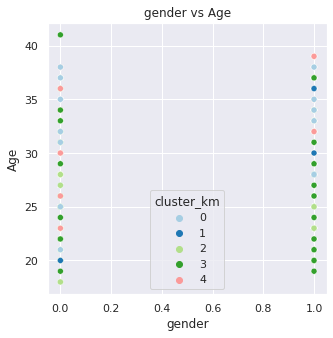

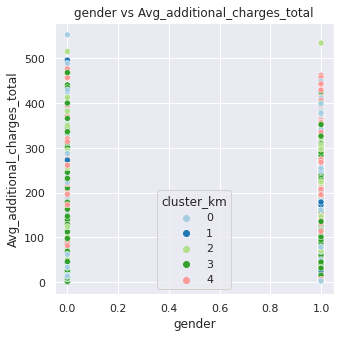

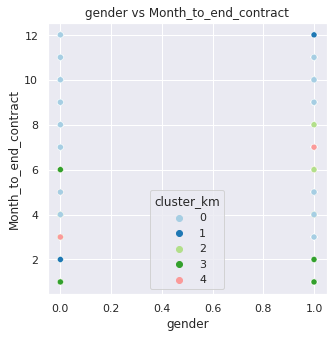

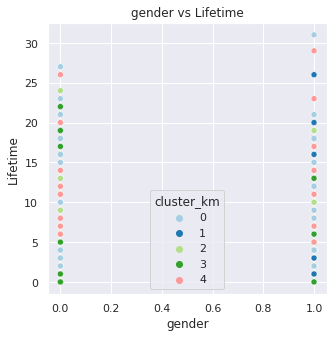

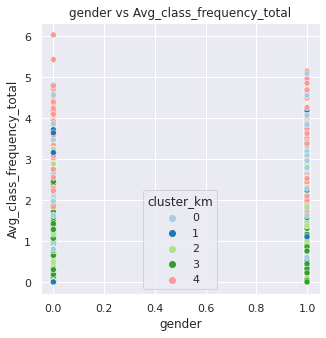

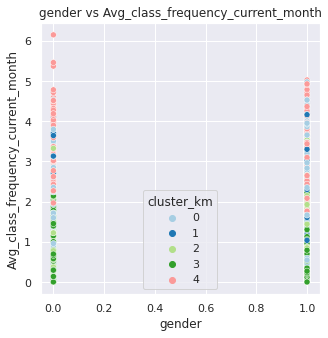

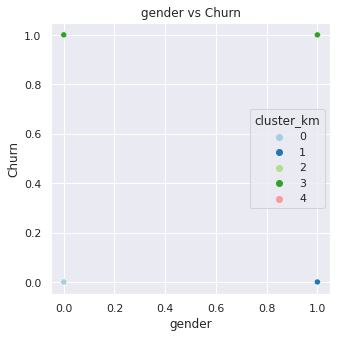

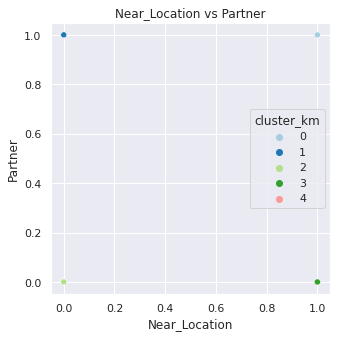

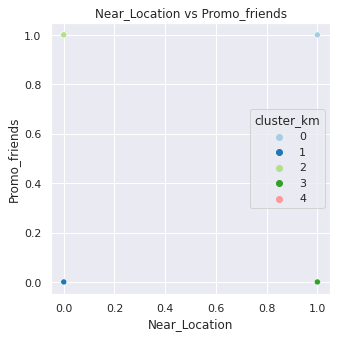

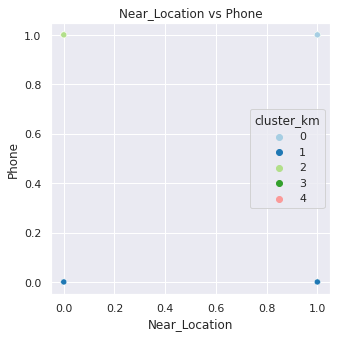

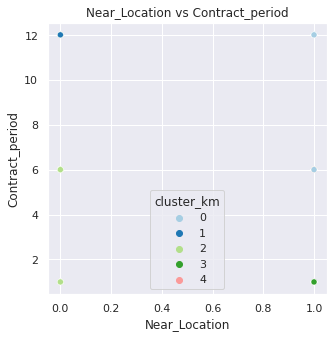

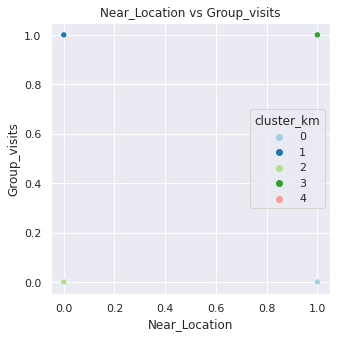

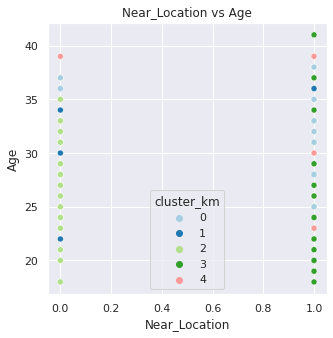

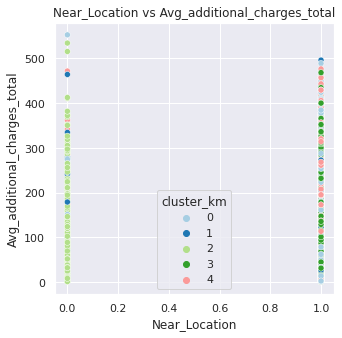

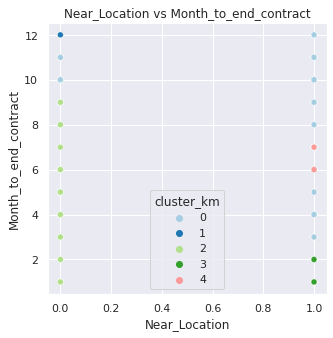

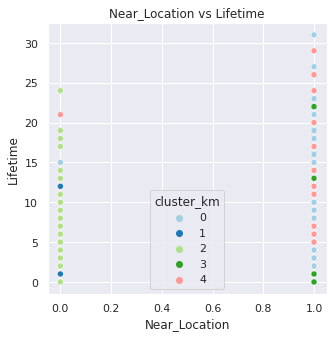

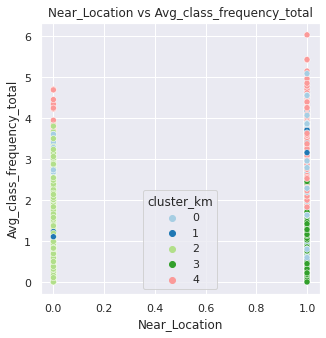

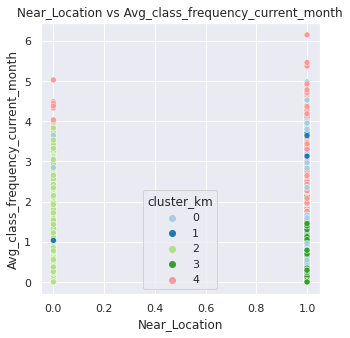

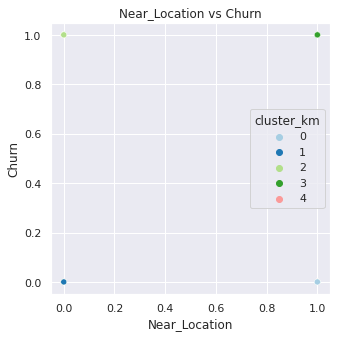

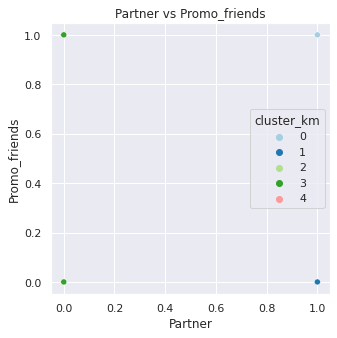

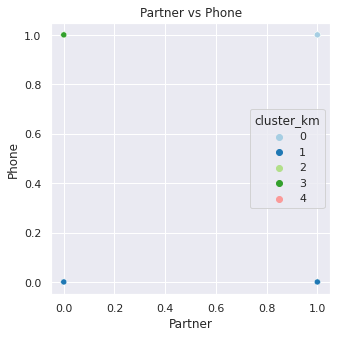

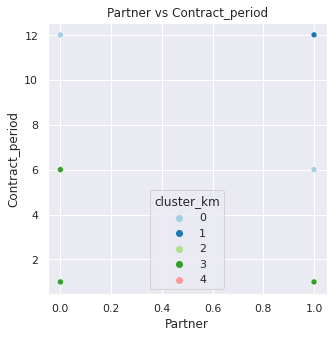

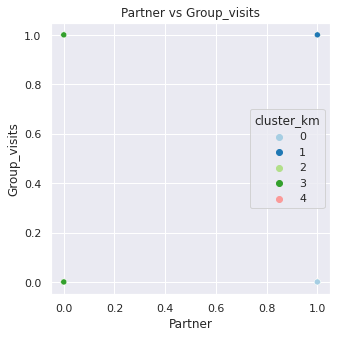

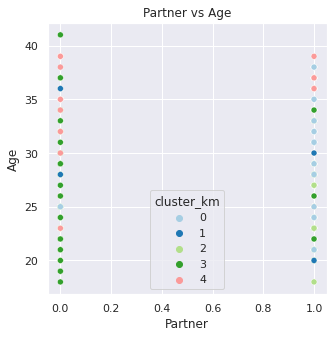

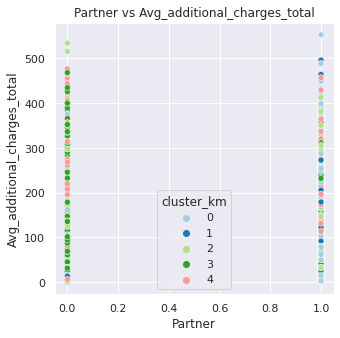

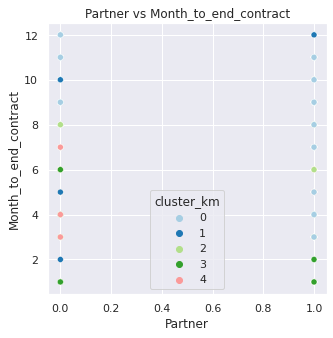

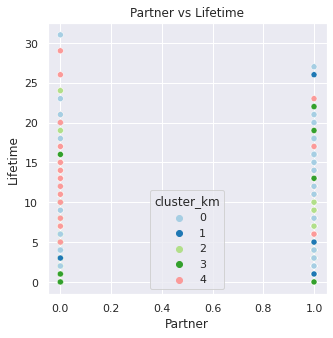

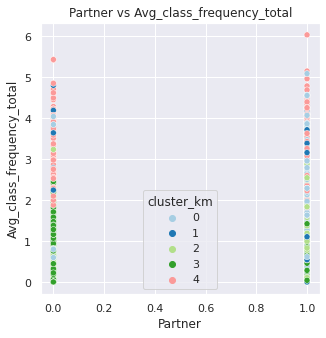

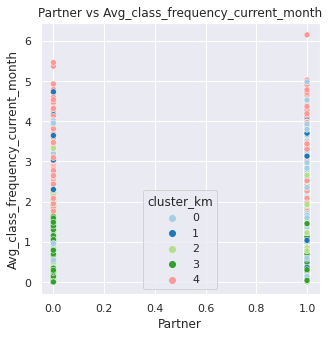

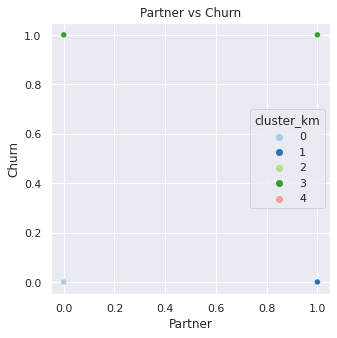

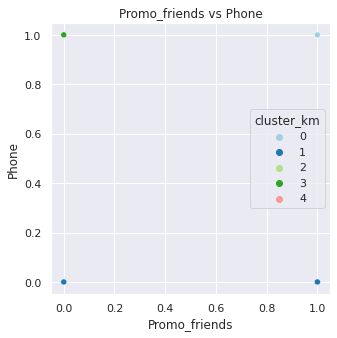

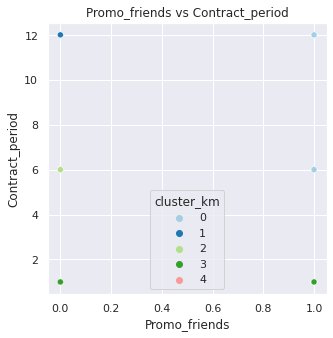

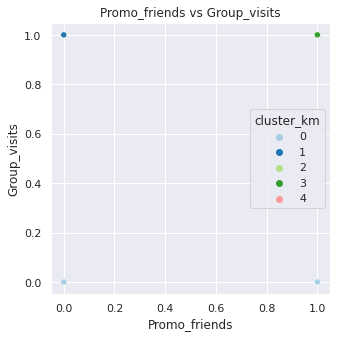

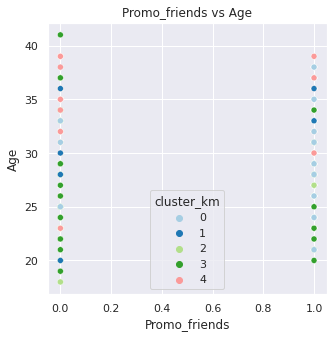

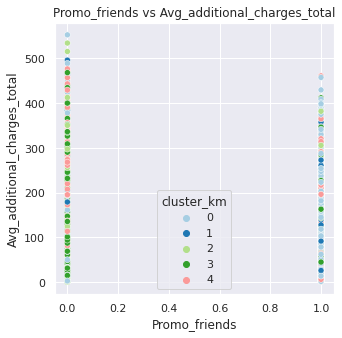

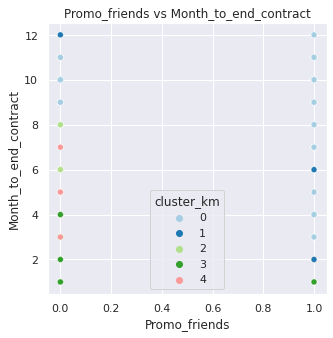

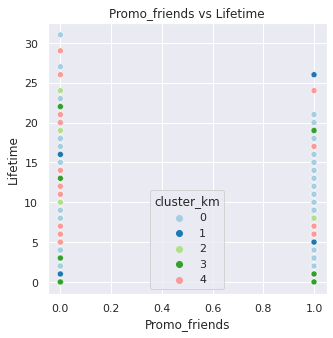

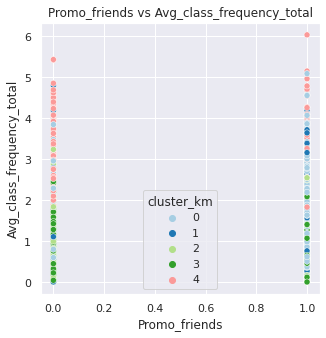

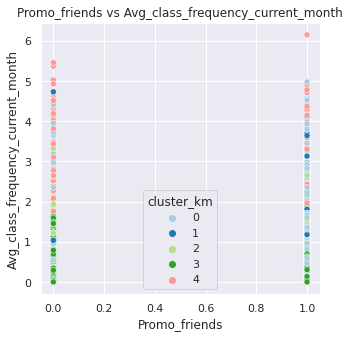

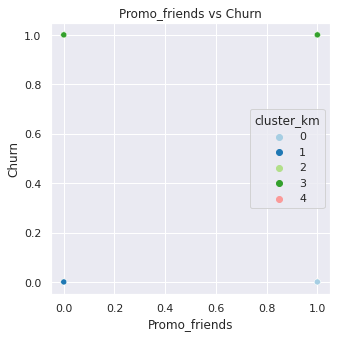

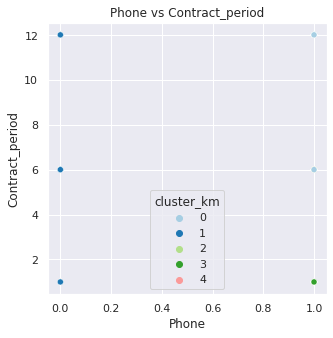

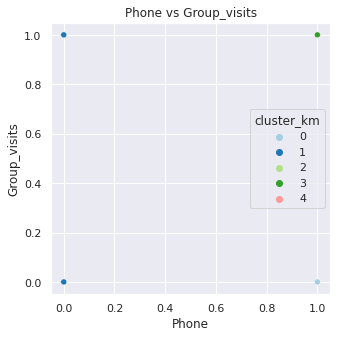

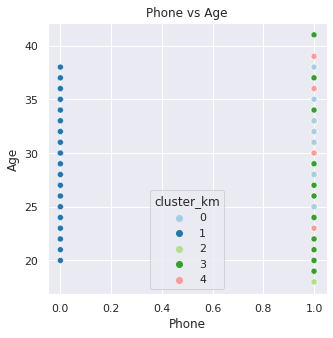

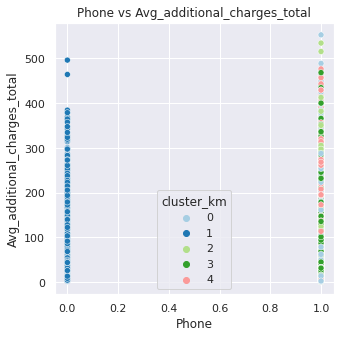

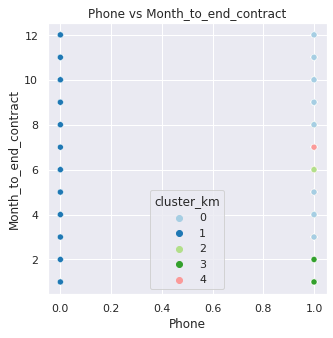

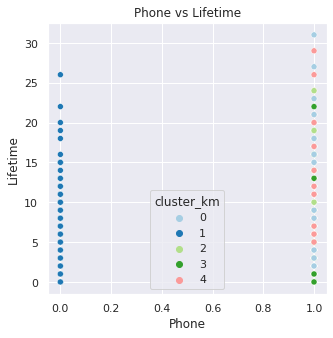

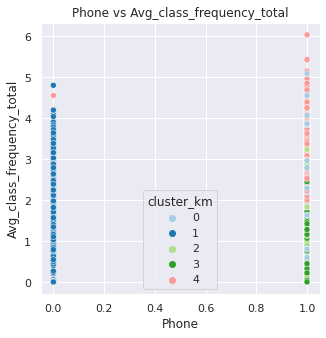

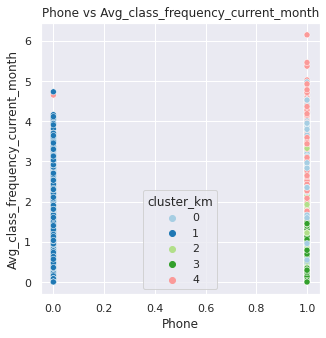

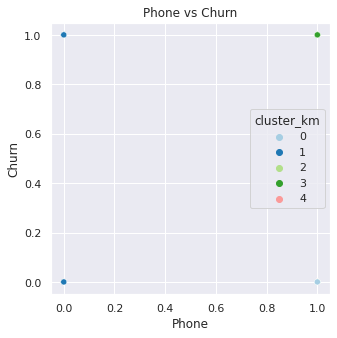

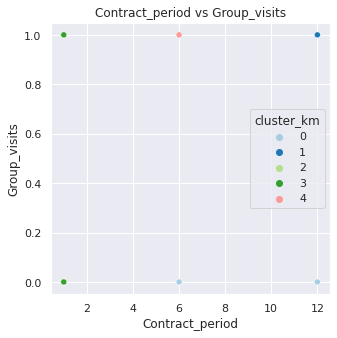

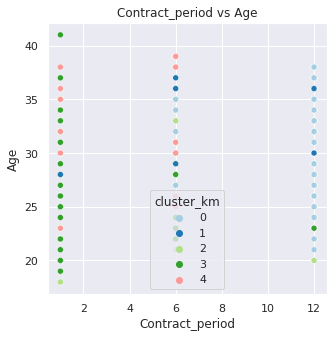

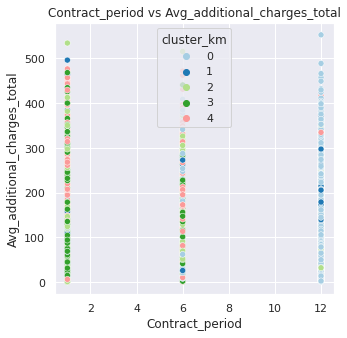

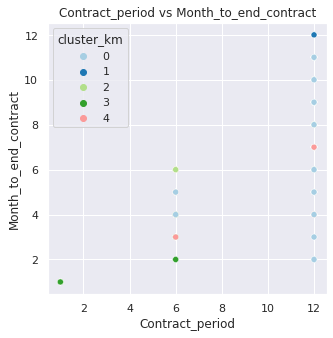

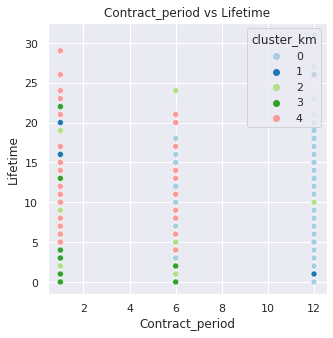

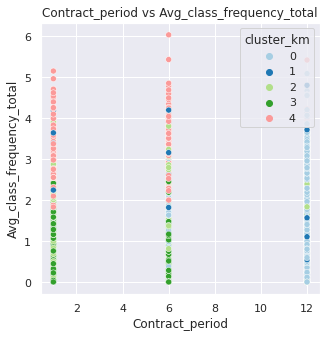

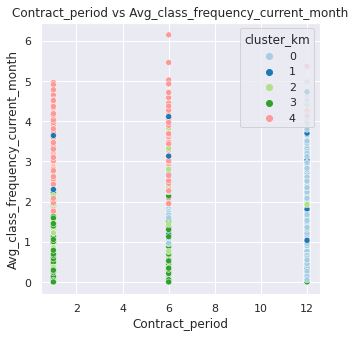

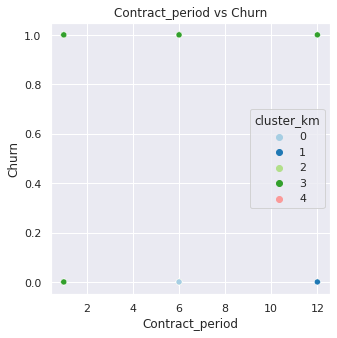

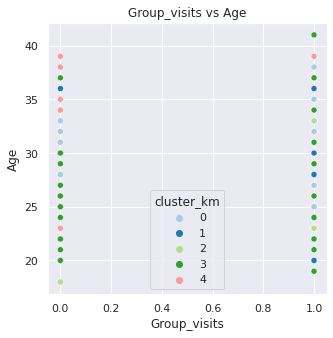

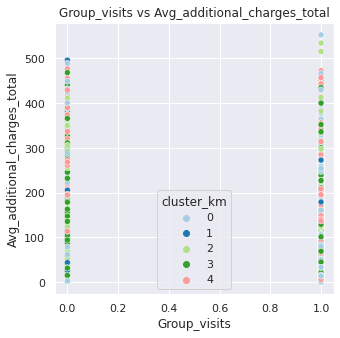

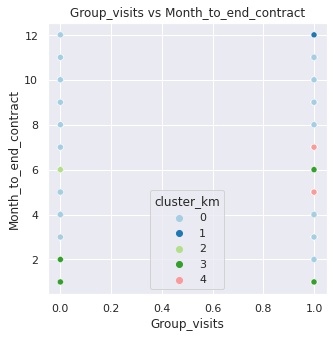

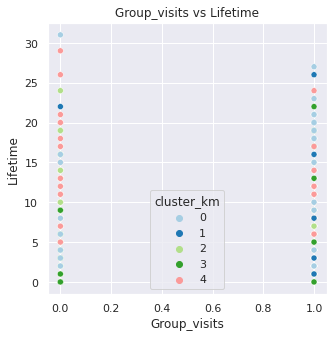

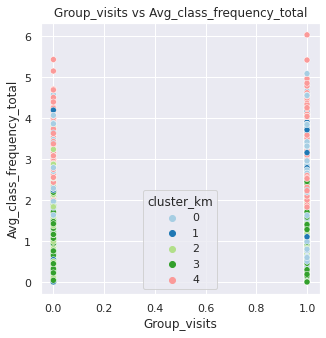

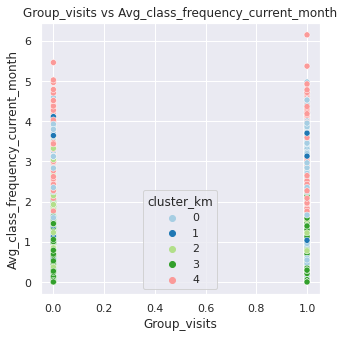

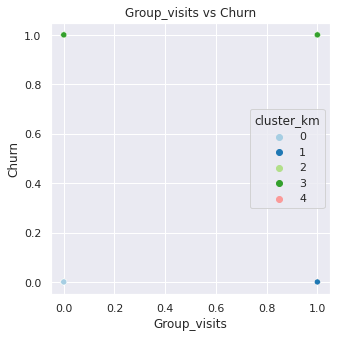

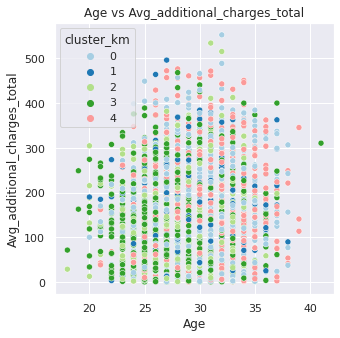

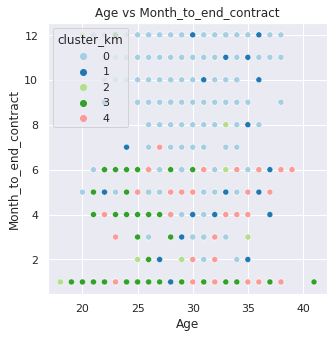

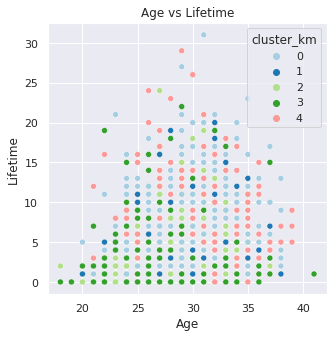

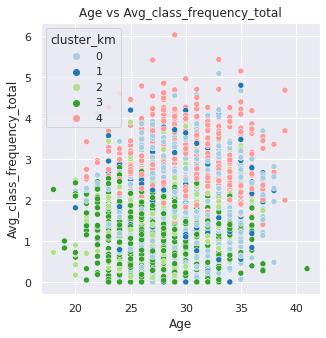

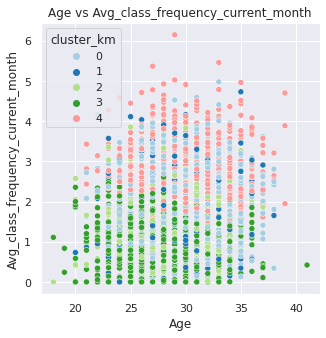

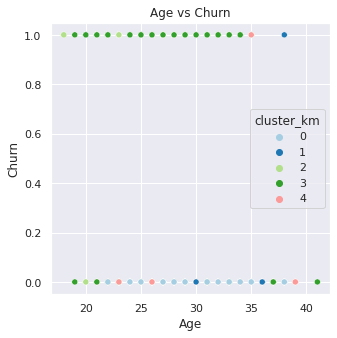

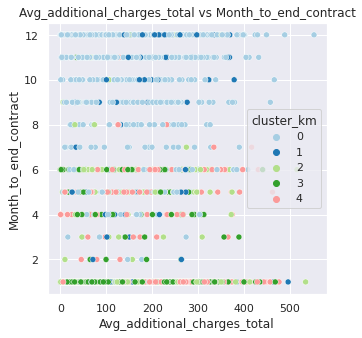

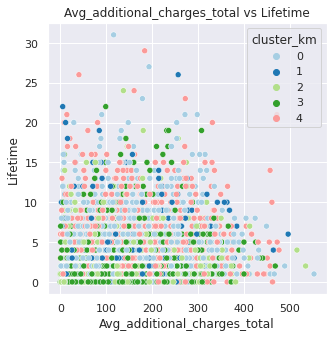

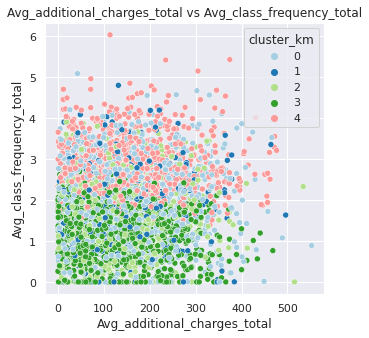

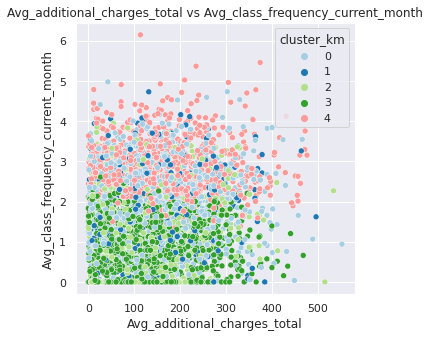

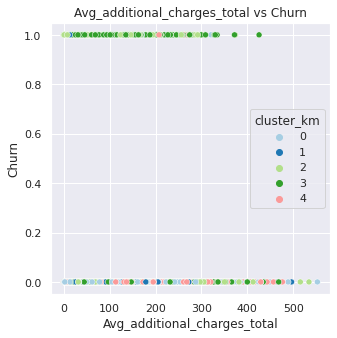

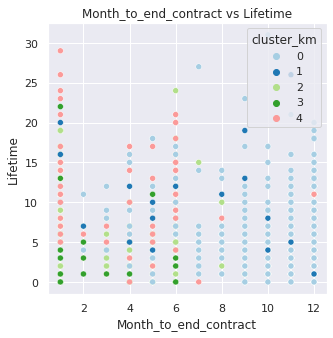

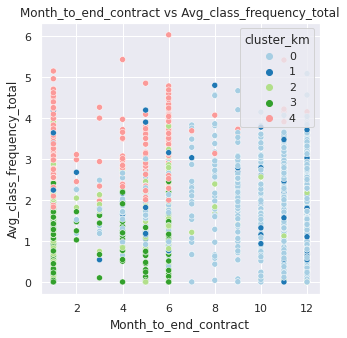

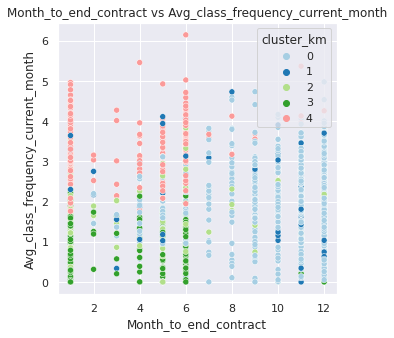

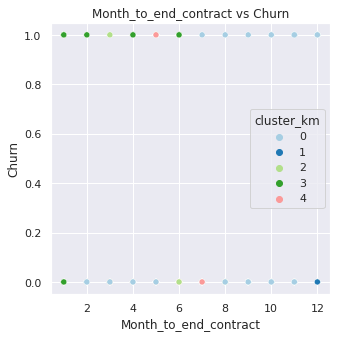

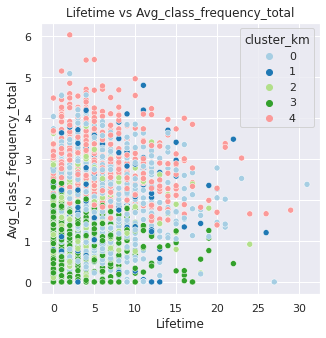

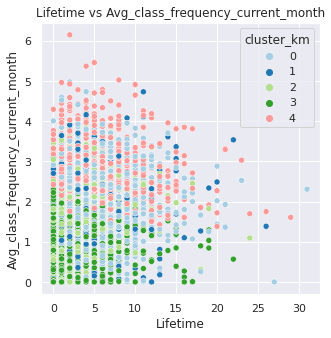

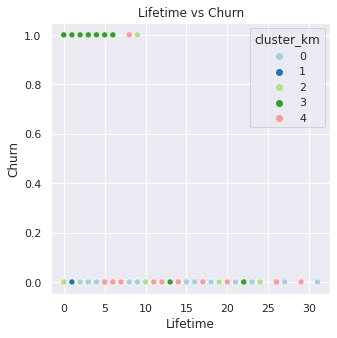

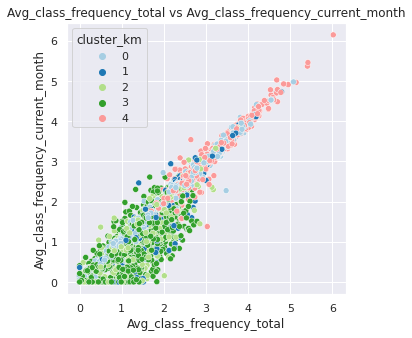

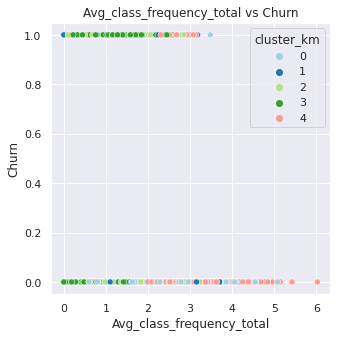

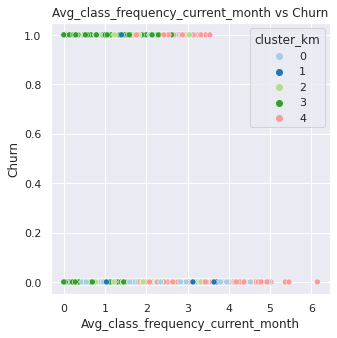

In [53]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(data.drop('cluster_km', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(data, pair[0], pair[1], 'cluster_km')

Распределения показывают, что пользователи из кластера 3 реже посещают занятия, приносят меньше дополнительного дохода и также покупают абонемент на меньший срок, чем пользователи других кластеров.

### Рассчет доли оттока

In [54]:
#сгруппируем по кластеру и рассчитаем среднее значение
data.groupby('cluster_km')['Churn'].mean()

cluster_km
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: Churn, dtype: float64

Наиболее надежный кластер 0.  
Наименее надежный кластер 3.

## Выводы и рекомендации

В ходе исследования было выявлено, что оттоку подвержены пользователи, которые: 
- покупают абонемент на небольшой период времени 
- редко посещают занятия

Исходя из этого, можно предложить следующие рекомендации: 

1. Мотивировать клиентов покупать абонемент на больший период. Например, с помощью программы скидок
1. Мотивировать клиентов чаще посещать фитнес-центр. Например, искусственно ограничить количество посещений в месяц. Таким образом у клиента будет создаваться ощущение, что он оплатил определенное кол-во занятий и их надо посетить, чтобы не пропадали деньги. 